In [1]:
%matplotlib inline
import requests as http
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from lib.lastfm import Lastfm
from lib.spotify import User
import time
import calendar
import datetime
import re
import unicodedata

pd.options.display.max_rows = 20
api_key = 'b333a19b2c0397e8e4c1224b49b3e7cd'
api_base = 'http://ws.audioscrobbler.com/2.0/?format=json&'
user_name = 'dude0faw3'
data = http.get(api_base + 'method=user.getrecenttracks&limit=200&api_key='\
                + api_key + '&user=' + user_name).json()

In [2]:
token = 'BQDCyccLfzo1ZcWMwP2BmrldK1VPt3g53D4NYOcKq9z4qTvT4YKe8pTf1EAxI3CvJC4spizgzeCiLq6cowW3jOB0gz9QBLAI0AmF9BWvnPJpE-f8kN2bM-tefL-O3aJPl-PmBayEV7PHCpMZLAUIVymqk6uNcmWrhWOXaZxsZaKTRZarIzFOvUfmE9MbExHxN96aOaDqjTFa'
received_features = ['danceability', 'energy', 'acousticness', 'valence', 'tempo']
user = User(received_features, 40, token=token)
lastfm = Lastfm()

Jewels & Dreams
Sultan + Shepard 
Meg & Dia
Jenna G and Futurebound
T.I. & Playboy Tre


In [3]:
track_data = data['recenttracks']['track']
limit = data['recenttracks']['@attr']['totalPages']
page = 1
history = []
# for nested dictionary entry requests
class FakeNone:
    def get(*args):
        return FakeNone()
# ensures that there's no key error exception
def check_track(track):
    arr = [track.get('name', FakeNone()),
     track.get('artist', FakeNone()).get('#text', FakeNone()),
      track.get('date', FakeNone()).get('uts', FakeNone())
    ]
    return [None if type(x) == FakeNone else x for x in arr]

for track in track_data:
    history.append(check_track(track))
    
print('Starting! There are ' + limit + ' pages')
while int(data['recenttracks']['@attr']['page']) is not int(limit):
    if page % 25 is 0:
        print('Page %i' % page)
    page += 1
    data = http.get(api_base + 'method=user.getrecenttracks&limit=200&api_key=' + api_key + \
                    '&user=' + user_name + '&page=' + str(page)).json()
    for track in data['recenttracks']['track']:
        history.append(check_track(track))



Starting! There are 162 pages
Page 25
Page 50
Page 75
Page 100
Page 125
Page 150


## Goals:
- most listened to songs / artists (as well as during a time)
- songs/artists you've neglected
- genres (tags)

In [4]:
history_df = pd.DataFrame(history)
history_df.columns = ['track_name', 'artists', 'date']
history_df

,track_name,artists,date
0,Set Yourself Free,Tiësto,1487745361
1,Let's Go,Travis Barker,1487745171
2,Act Like You Know - Dubstep Mix,Nero,1487744836
3,Where's my Money - Caspa Remix,TC,1487744569
4,Cracks - Flux Pavilion Remix,Freestylers feat. Belle Humble,1487744292
5,Got 2 Know,Flux Pavilion,1487744054
6,Drifting,G-Eazy,1487743822
7,Alone,Armin van Buuren,1487743626
8,ECHO (LET GO),Breathe Carolina,1487742140
9,Sever the Ties (feat. Esther Sparkes),Arman Cekin,1487741995


In [9]:
# determine the n-most frequently played songs from a given pandas series
def determine_frequencies(data, num_songs, neglected=False):
    if neglected:
        counter = Counter(data)
        frequencies = counter.most_common()
        index = len(frequencies) - num_songs
        return frequencies[ index :]
    else:
        counter = Counter(data)
        return counter.most_common(num_songs)

# clean lastfm data to only have songs currently in spotify library
def refine_df(original_df, feature_name, must_haves):
    def check(val):
        for must_have in must_haves:
            if must_have.lower() == val.lower():
                return True
            
        return False
    arr_check = np.vectorize(check)
    return original_df[ arr_check(original_df[ feature_name ]) ]

def set_count(spotify):
    count_arr = [None] * len(spotify)
    for row in spotify.itertuples():
        count = occurences_in_history(row.track_name, row.artists)
        count_arr[row.Index] = count
    spotify['count'] = pd.Series(count_arr)
    
history_songs = history_df['track_name'].values
history_artists = history_df['artists'].values

def occurences_in_history(track_name, track_artist):
    count = 0
    track_artists = track_artists.split(',')
    for track, history_artist in zip(history_songs, history_artists):
        # ignore potential formatting differences
        if track.lower() == track_name.lower():
            for artist in track_artists:
                if strip_accents(artist.lower()) == strip_accents(history_artist.lower()):
                    count += 1
    return count


def strip_accents(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)
        
songs = user.library['track_name']
history_df = refine_df(history_df, 'track_name', songs)
set_count(user.library)

In [10]:
user.library

,track_name,track_id,artists,popularity,genres,danceability,energy,acousticness,valence,tempo,count
0,Alive - 2006 Remastered Version,3IRovqSVYx3CNtDWRebsET,P.O.D.,57,"numetal,rapcore",0.409,0.952,0.000012,0.5580,80.899,5
1,OWM,3wwmrdvgaHPnwKxJ4wCnW6,GITCHII,25,,0.488,0.774,0.000386,0.0478,129.820,9
2,Trojans - Xaphoon Jones Remix,1AUT0H87ysQgfRtVWWcrTZ,"Atlas Genius,Xaphoon Jones",36,"indierock,electronic,chiddybang,mashup",0.729,0.643,0.024800,0.4080,140.061,15
3,Pvrple Forest - Original Mix,5SI3WZ3UyZU8SQzRqPwSzR,GANZ,30,"electronic,seenlive",0.540,0.758,0.000656,0.2110,142.131,5
4,Right Now,1tiC8QJASx6lGHBMEpFawS,"Fabian Mazur,Luude",55,"trap,hiphop,futurebass",0.608,0.758,0.144000,0.3310,140.031,6
5,Beautiful Girls,5EuAj9nZiWRKeBkgxMXsW4,Sean Kingston,14,"rnb,hiphop",0.745,0.666,0.159000,0.7270,129.995,17
6,Cry Me a River,7Lf7oSEVdzZqTA0kEDSlS5,Justin Timberlake,70,"pop,rnb",0.624,0.653,0.575000,0.5880,73.884,2
7,Since U Been Gone,3xrn9i8zhNZsTtcoWgQEAd,Kelly Clarkson,69,"pop,femalevocalists",0.662,0.741,0.001650,0.4090,131.000,3
8,Kryptonite,6ZOBP3NvffbU4SZcrnt1k6,3 Doors Down,68,"rock,alternativerock",0.545,0.860,0.006240,0.5910,99.031,16
9,Stellar - Morgan Page Remix,5eleUvVKuyL8mvOpkEIS2q,"Disco Killerz,Liquid Todd,Jimmy Gnecco,Morgan ...",42,",,house,electronica,singersongwriter,rock,hous...",0.520,0.923,0.042700,0.1840,128.004,0


In [11]:
class TimeMachine:
    
    def __init__(self, year):
        self.seasons = {
            'spring': ( time.strptime('21 Mar ' + year, '%d %b %Y'),
                      time.strptime('21 Jun ' + year, '%d %b %Y')),
            'summer': ( time.strptime('21 Jun ' + year, '%d %b %Y'),
                      time.strptime('23 Sep ' + year, '%d %b %Y')),
            'fall': ( time.strptime('23 Sep ' + year, '%d %b %Y'),
                      time.strptime('21 Dec ' + year, '%d %b %Y')),
            'winter': ( time.strptime('21 Dec ' + year, '%d %b %Y'),
                        time.strptime('21 Mar ' + str(int(year) + 1), '%d %b %Y'))
        }
        self.year = year
        
    def set_year(self, new_year):
        self = self.__init__(new_year)
        
    def in_season(self, season, df):
        timeslice = self.seasons[season]
        def check_time(seconds):
            try:
                listen_time =  time.gmtime(int(seconds))
            except TypeError:
                return False
            return listen_time > timeslice[0] and listen_time < timeslice[1]
        arr_time_check = np.vectorize(check_time)
        return df[arr_time_check(df['date'])]
    
    def in_year(self, df):
        date = datetime.date(int(self.year), 1, 1)
        def check_time(seconds):
            try: 
                listen_time =  datetime.date.fromtimestamp(int(seconds))
            except TypeError:
                return False
            return listen_time.year == date.year
        arr_time_check = np.vectorize(check_time)
        return df[ arr_time_check(df['date'])]
    


In [37]:
# make a timemachine to 2014, check out top artists from then
obj = TimeMachine('2014')
year_df = obj.in_year(history_df)
determine_frequencies(year_df['artists'], 20)
year_df

,track_name,artists,date
28230,Around the World,Daft Punk,1420084205
28231,Alone,Armin van Buuren,1420083968
28232,If I Lose Myself - Alesso vs OneRepublic,OneRepublic,1420000710
28233,Whistle,Flo Rida,1420000484
28234,Relentless,Blackmill,1420000290
28235,Playground [feat. Bugle & Arama],Major Lazer,1420000055
28237,Where's my Money - Caspa Remix,TC,1419999518
28238,Keep on Dancing,Doctor P,1419999257
28239,Promises - Skrillex & Nero Remix,Nero,1419998931
28240,"Wild One Two - feat. David Guetta, Nicky Romer...",Jack Back,1419998585


In [13]:
user.library.head()

,track_name,track_id,artists,popularity,genres,danceability,energy,acousticness,valence,tempo,count
0,Alive - 2006 Remastered Version,3IRovqSVYx3CNtDWRebsET,P.O.D.,57,"numetal,rapcore",0.409,0.952,0.000012,0.5580,80.899,5
1,OWM,3wwmrdvgaHPnwKxJ4wCnW6,GITCHII,25,,0.488,0.774,0.000386,0.0478,129.820,9
2,Trojans - Xaphoon Jones Remix,1AUT0H87ysQgfRtVWWcrTZ,"Atlas Genius,Xaphoon Jones",36,"indierock,electronic,chiddybang,mashup",0.729,0.643,0.024800,0.4080,140.061,15
3,Pvrple Forest - Original Mix,5SI3WZ3UyZU8SQzRqPwSzR,GANZ,30,"electronic,seenlive",0.540,0.758,0.000656,0.2110,142.131,5
4,Right Now,1tiC8QJASx6lGHBMEpFawS,"Fabian Mazur,Luude",55,"trap,hiphop,futurebass",0.608,0.758,0.144000,0.3310,140.031,6


In [14]:
common_genres = [
    'hiphop',
    'rap',
    'pop',
    'rock',
    'rnb',
    'dubstep',
    'trance',
    'house',
    'trap',
    'country',
    'alternative',
    'indie',
    'reggae'
]

library_genres = user.library['genres']
def count_appearances(match_genre):
    count = 0
    for track_genre in library_genres:
        track_genre = track_genre.split(',')
        for genre in track_genre:
            if genre == match_genre:
                count += 1
    return count

count = [count_appearances(genre) for genre in common_genres]
top_genres = []
for common_genre, genre_count in zip(common_genres, count):
    top_genres.append([common_genre, genre_count])
top_genres

[['hiphop', 242],
 ['rap', 176],
 ['pop', 98],
 ['rock', 78],
 ['rnb', 79],
 ['dubstep', 208],
 ['trance', 36],
 ['house', 106],
 ['trap', 44],
 ['country', 1],
 ['alternative', 18],
 ['indie', 32],
 ['reggae', 10]]

In [15]:
def filter_for_genre(genre, df):
    truth_arr = [False] * len(df)
    for index, genres in enumerate(df['genres']):
        genres = genres.split(',')
        if genre in genres:
            truth_arr[index] = True
    return df[truth_arr]

filter_for_genre('rap', user.library)

,track_name,track_id,artists,popularity,genres,danceability,energy,acousticness,valence,tempo,count
15,Know Yourself,1d9AWpbn0IF95ZlgsfqAKE,Drake,36,"hiphop,rap",0.759,0.397,0.18600,0.1660,114.657,23
16,Now and Later,43jBqV3j3Xi1g6wO0bhIMd,Sage The Gemini,88,"hiphop,rap",0.781,0.570,0.27300,0.8580,107.059,12
17,Young Man,3CBDwRy9pnR05AWXDCZLWK,"Machine Gun Kelly,Chief Keef",26,"hiphop,rap,hiphop,rap",0.840,0.334,0.03750,0.0370,109.973,5
21,Febreze (feat. 2 Chainz),48bSfSZaq9Aizbu4AWn4st,"Jack Ü,Skrillex,Diplo,2 Chainz",60,"electronic,trap,dubstep,electronic,electronic,...",0.680,0.983,0.01840,0.2920,149.829,12
22,Losin Control,1jkIErXa3YNUX5QIyO6GGR,Russ,75,"rap,underlisteners",0.761,0.250,0.55800,0.2490,96.992,23
25,Rebel,0htTZnlk6okQ1HIq4EvFQ6,G-Eazy,51,"hiphop,rap",0.682,0.911,0.14300,0.5540,140.079,2
32,Who Knew,2AqGzt3g1L447rpkfqByiR,Lil Dicky,53,"hiphop,rap",0.755,0.787,0.32500,0.5720,91.026,6
36,Same Old Song,3nE2A8sGDAI2nzGSI8Rzd6,"The Weeknd,Juicy J",31,"rnb,electronic,hiphop,rap",0.746,0.565,0.38700,0.3520,109.959,37
39,The Zone - Album Version (Edited),5zggls08Fw43MEb2r9kSUW,"The Weeknd,Drake",33,"rnb,electronic,hiphop,rap",0.608,0.525,0.27500,0.2670,139.978,14
49,Ni**as In Paris,4Li2WHPkuyCdtmokzW2007,"JAY Z,Kanye West",72,"hiphop,rap,hiphop,rap",0.788,0.859,0.12700,0.7650,140.027,0


In [16]:
determine_frequencies(history_df['track_name'].values, 10, neglected=True)

[('Tumblr Girls', 3),
 ('Valerie', 3),
 ('Slowly - Radio Edit', 3),
 ('We Come Running - Tiësto Remix', 2),
 ('Rebel', 2),
 ('Downtown Love', 2),
 ('Many Ways - Radio Edit', 2),
 ('Flexicution', 2),
 ('The Distance', 1),
 ('bring me to life', 1)]

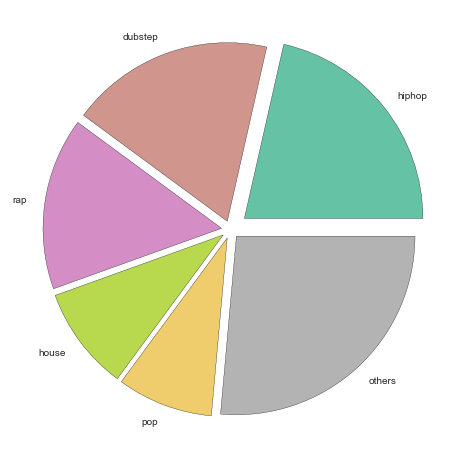

In [17]:
sorted_top_genres = sorted(top_genres, key=lambda x: x[1], reverse=True)
top_four = sorted_top_genres[:5]
others = 0
for genre in sorted_top_genres[5:]:
    others += genre[1]
labels = [elem[0] for elem in top_four]
labels.append('others')
values = [elem[1] for elem in top_four]
values.append(others)
explode = [0.1, 0.05, 0.05, 0.05, 0.05, 0.05]
plt.figure(figsize=(8,8))
plt.pie(values, labels=labels, colors=plt.cm.Set2(np.arange(0, 6)/5), explode=explode)
plt.show()

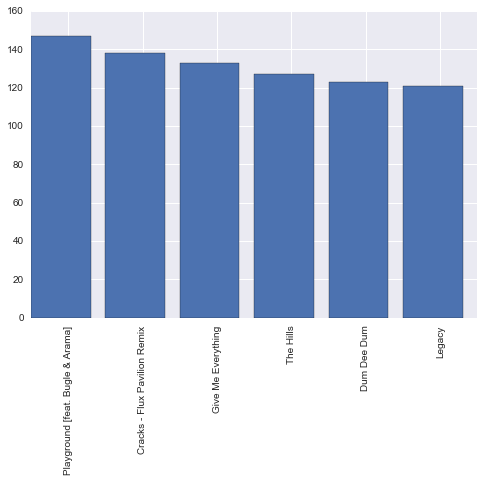

In [18]:
sorted_values = user.library.sort_values('count', ascending=False).values
top_five_values = sorted_values[:6, -1]
top_five_names = sorted_values[:6, 0]
xaxis = np.arange(0, 6)
plt.bar(xaxis, top_five_values)
plt.xticks(xaxis + 0.5, top_five_names, rotation=90)
plt.show()

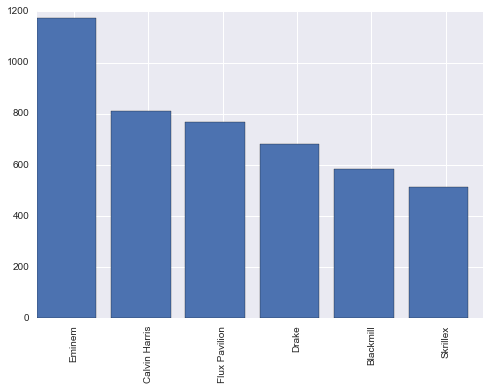

In [19]:
def count_artist(artist_name, df):
    def has_artist(artists):
        list_artists = artists.split(',')
        for artist in list_artists:
            if artist.lower() == artist_name.lower():
                return True
        return False
    has_artist = np.vectorize(has_artist)
    artist_df = df[ has_artist(df['artists'])]
    counts = artist_df['count']
    return counts.sum()
    
count_artist('Eminem', user.library)
artist_play_counts = [count_artist(name, user.library) for name in user.artists]
artists_df = pd.DataFrame( {
        'artist_name': user.artists,
        'play_count': artist_play_counts
    })
sorted_play_counts = artists_df.sort_values('play_count', ascending=False).values
top_five_artist_names = sorted_play_counts[:6, 0]
top_five_artist_plays = sorted_play_counts[:6, 1]
xaxis = np.arange(0, 6)
plt.bar(xaxis, top_five_artist_plays)
plt.xticks(xaxis + 0.5, top_five_artist_names, rotation=90)
plt.show()

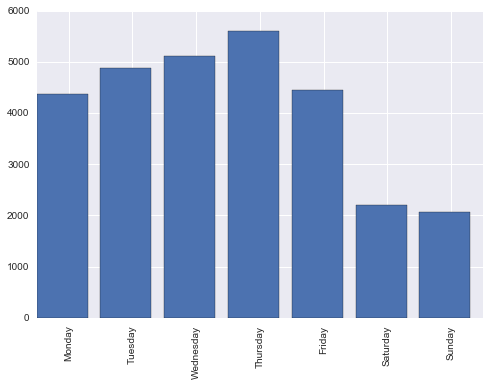

In [20]:
times = history_df['date'].values
def get_wkday(seconds):
    gmtime = time.gmtime(int(seconds))
    return gmtime.tm_wday
get_wkday = np.vectorize(get_wkday)
wkday_counts = Counter(get_wkday(times)).most_common()
wkday_counts.sort(key=lambda x: x[0])
days, counts = zip(*wkday_counts)
days = np.array(days)
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.bar(days, counts)
plt.xticks(days + 0.5, weekdays, rotation=90)
plt.show()

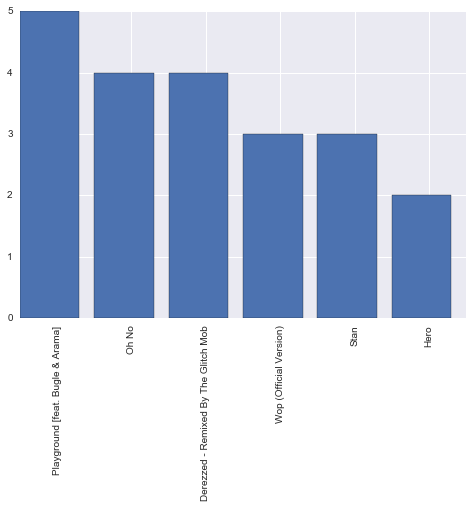

In [21]:
track_history = history_df['track_name'].values
def count_repeats(track_name, index):
    count = 0
    while index < len(track_history) - 1 and track_history[index + 1] == track_name:
        count += 1
        index += 1
    return count
repeated_songs = {}
for index, track in enumerate(track_history):
    repeats = count_repeats(track, index)
    if track in repeated_songs:
        if repeats > repeated_songs[track]:
            repeated_songs[track] = repeats
    elif repeats > 0:
        repeated_songs[track] = repeats
        
repeated_song_titles = list(repeated_songs.keys())
repeated_song_counts = [repeated_songs[track] for track in repeated_song_titles]
repeated_df = pd.DataFrame({
        'track_names': repeated_song_titles,
        'count': repeated_song_counts
    })
sorted_values = repeated_df.sort_values('count', ascending=False).values
values = sorted_values[:6, 0]
names = sorted_values[:6, 1]
xaxis = np.arange(0, 6)
plt.bar(xaxis, values)
plt.xticks(xaxis + 0.5, names, rotation=90)
plt.show()

In [22]:
history_df

,track_name,artists,date
0,Set Yourself Free,Tiësto,1487745361
1,Let's Go,Travis Barker,1487745171
2,Act Like You Know - Dubstep Mix,Nero,1487744836
3,Where's my Money - Caspa Remix,TC,1487744569
4,Cracks - Flux Pavilion Remix,Freestylers feat. Belle Humble,1487744292
5,Got 2 Know,Flux Pavilion,1487744054
6,Drifting,G-Eazy,1487743822
7,Alone,Armin van Buuren,1487743626
8,ECHO (LET GO),Breathe Carolina,1487742140
9,Sever the Ties (feat. Esther Sparkes),Arman Cekin,1487741995


## References
Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011)

John D. Hunter, "Matplotlib: A 2D Graphics Environment", Computin

Raschka, Sebastian, and Randal S. Olson. Python Machine Learning: Unlock Deeper Insights into Machine    Learning with This Vital Guide to Cutting-edge Predictive Analytics. Birmingham: Packt, 2015. Print.g in Science & Engineering, vol.9, no. 3, pp. 90-95, May/June 2007, doi:10.1109/MCSE.2007.55  

In [23]:
plt.cm.Accent(np.arange(0, 6))

array([[ 0.49803922,  0.78823531,  0.49803922,  1.        ],
       [ 0.50482122,  0.78532873,  0.50718954,  1.        ],
       [ 0.51160323,  0.78242216,  0.51633987,  1.        ],
       [ 0.51838524,  0.77951558,  0.5254902 ,  1.        ],
       [ 0.52516725,  0.77660901,  0.53464052,  1.        ],
       [ 0.53194925,  0.77370244,  0.54379085,  1.        ]])

In [24]:
import importlib
import lib.curator as curator

In [36]:
importlib.reload(curator)
curator.tag_filter(user.library, 'rap')

,track_name,track_id,artists,popularity,genres,danceability,energy,acousticness,valence,tempo,count
15,Know Yourself,1d9AWpbn0IF95ZlgsfqAKE,Drake,36,"hiphop,rap",0.759,0.397,0.186000,0.1660,114.657,23
16,Now and Later,43jBqV3j3Xi1g6wO0bhIMd,Sage The Gemini,88,"hiphop,rap",0.781,0.570,0.273000,0.8580,107.059,12
17,Young Man,3CBDwRy9pnR05AWXDCZLWK,"Machine Gun Kelly,Chief Keef",26,"hiphop,rap,hiphop,rap",0.840,0.334,0.037500,0.0370,109.973,5
21,Febreze (feat. 2 Chainz),48bSfSZaq9Aizbu4AWn4st,"Jack Ü,Skrillex,Diplo,2 Chainz",60,"electronic,trap,dubstep,electronic,electronic,...",0.680,0.983,0.018400,0.2920,149.829,12
22,Losin Control,1jkIErXa3YNUX5QIyO6GGR,Russ,75,"rap,underlisteners",0.761,0.250,0.558000,0.2490,96.992,23
25,Rebel,0htTZnlk6okQ1HIq4EvFQ6,G-Eazy,51,"hiphop,rap",0.682,0.911,0.143000,0.5540,140.079,2
32,Who Knew,2AqGzt3g1L447rpkfqByiR,Lil Dicky,53,"hiphop,rap",0.755,0.787,0.325000,0.5720,91.026,6
36,Same Old Song,3nE2A8sGDAI2nzGSI8Rzd6,"The Weeknd,Juicy J",31,"rnb,electronic,hiphop,rap",0.746,0.565,0.387000,0.3520,109.959,37
39,The Zone - Album Version (Edited),5zggls08Fw43MEb2r9kSUW,"The Weeknd,Drake",33,"rnb,electronic,hiphop,rap",0.608,0.525,0.275000,0.2670,139.978,14
49,Ni**as In Paris,4Li2WHPkuyCdtmokzW2007,"JAY Z,Kanye West",72,"hiphop,rap,hiphop,rap",0.788,0.859,0.127000,0.7650,140.027,0


In [40]:
token = 'BQDCyccLfzo1ZcWMwP2BmrldK1VPt3g53D4NYOcKq9z4qTvT4YKe8pTf1EAxI3CvJC4spizgzeCiLq6cowW3jOB0gz9QBLAI0AmF9BWvnPJpE-f8kN2bM-tefL-O3aJPl-PmBayEV7PHCpMZLAUIVymqk6uNcmWrhWOXaZxsZaKTRZarIzFOvUfmE9MbExHxN96aOaDqjTFa'
test_user = User(received_features, 40, token=token)

KeyboardInterrupt: 